# Segmentation of Multiple Sclerosis with Brain MRI dataset

This Jupyter notebook is designed to explore and utilize a Brain MRI dataset of patients with Multiple Sclerosis (MS) for the purpose of predicting lesions. Multiple Sclerosis is a chronic illness characterized by the presence of lesions in the brain and spinal cord, leading to a wide range of neurological symptoms. Detecting and monitoring these lesions using MRI is a critical part of diagnosing and managing the disease.

The dataset used in this notebook is sourced from a research publication by M Muslim (2022) and includes MRI scans along with consensus manual lesion segmentation. This provides an adequate resource for training and evaluating AI models in medical imaging applications.


## Data Loading

In this section, we will download the Brain MRI dataset from the Mendeley Data repository, organize the data into training, testing, and validation sets, and prepare it for analysis.

The dataset consists of MRI scans from 60 patients, each stored in separate folders. We will:

1. Download the dataset, which is provided as a ZIP file.
2. Extract the contents of the ZIP file.
3. Perform exploratory data analysis (e.g. number of slices, image shapes, number of slices with lesions).
4. Randomly allocate 40 patient folders to a training set, 10 to a testing set, and the remaining 10 to a validation set, ensuring reproducibility by setting a random seed.


In [ ]:
!pip install nibabel

In [1]:
import os
import random
import shutil
import requests
from zipfile import ZipFile

# Define the URL of the dataset
dataset_url = "https://data.mendeley.com/public-files/datasets/8bctsm8jz7/files/9356efeb-dcd8-4213-a2d4-8febe9f1a5db/file_downloaded"
zip_filename = "Brain MRI Dataset of Multiple Sclerosis with Consensus Manual Lesion Segmentation and Patient Meta Information.zip"
extracted_folder = "brain_mri_dataset"

# Function to download the dataset
def download_dataset(url, filename):
    response = requests.get(url, stream=True)
    with open(filename, 'wb') as f:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
    print(f"Downloaded {filename}")

# Function to extract the dataset
def extract_dataset(zip_filename, extract_to):
    with ZipFile(zip_filename, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"Extracted {zip_filename} to {extract_to}")

# Main execution
if __name__ == "__main__":
    # Download the dataset
    download_dataset(dataset_url, zip_filename)

    # Extract the dataset
    extract_dataset(zip_filename, extracted_folder)

Downloaded Brain MRI Dataset of Multiple Sclerosis with Consensus Manual Lesion Segmentation and Patient Meta Information.zip
Extracted Brain MRI Dataset of Multiple Sclerosis with Consensus Manual Lesion Segmentation and Patient Meta Information.zip to brain_mri_dataset


## Exploratory Data Analysis

In [ ]:
import os
import nibabel as nib
import pandas as pd

# Define the root directory containing the patient folders
data_dir = "brain_mri_dataset"  # Change this to the location of your "brain_mri_dataset" folder

# List to store resolution information
resolution_info = []

# Iterate through each patient folder in the brain_mri_dataset
for patient_folder in os.listdir(data_dir):
    patient_path = os.path.join(data_dir, patient_folder)

    # Make sure it's a directory
    if os.path.isdir(patient_path):

        # Iterate through each file in the patient folder
        for file in os.listdir(patient_path):
            if file.endswith(".nii"):
                file_path = os.path.join(patient_path, file)

                # Load the .nii file using nibabel
                img = nib.load(file_path)
                header = img.header

                # Get the voxel dimensions (resolution)
                voxel_dimensions = header.get_zooms()  # Returns (x, y, z) dimensions

                # Get the shape of the image data, disregarding the third dimension
                image_shape = img.shape[:2]  # Only consider the first two dimensions (height, width)

                # Store the information in the list
                resolution_info.append({
                    "Patient": patient_folder,
                    "File": file,
                    "Voxel Dimensions": voxel_dimensions,
                    "Image Shape (HxW)": image_shape
                })

# Create a DataFrame to display the resolution information
resolution_df = pd.DataFrame(resolution_info)

# Display the DataFrame to check resolutions
print(resolution_df)

# Optional: Save the DataFrame to a CSV file for further analysis
resolution_df.to_csv("resolution_overview.csv", index=False)

        Patient                    File Voxel Dimensions Image Shape (HxW)
0    Patient-39     39-LesionSeg-T2.nii  (1.0, 1.0, 1.0)        (384, 282)
1    Patient-39     39-LesionSeg-T1.nii  (1.0, 1.0, 1.0)        (384, 282)
2    Patient-39            39-Flair.nii  (1.0, 1.0, 1.0)        (512, 368)
3    Patient-39               39-T2.nii  (1.0, 1.0, 1.0)        (384, 282)
4    Patient-39  39-LesionSeg-Flair.nii  (1.0, 1.0, 1.0)        (512, 368)
..          ...                     ...              ...               ...
355  Patient-25               25-T1.nii  (1.0, 1.0, 1.0)        (256, 256)
356  Patient-25     25-LesionSeg-T1.nii  (1.0, 1.0, 1.0)        (256, 256)
357  Patient-25     25-LesionSeg-T2.nii  (1.0, 1.0, 1.0)        (256, 256)
358  Patient-25            25-Flair.nii  (1.0, 1.0, 1.0)        (256, 256)
359  Patient-25  25-LesionSeg-Flair.nii  (1.0, 1.0, 1.0)        (256, 256)

[360 rows x 4 columns]


Analysis of voxel dimensions and image shapes to consider for pre-processing - the voxel dimension is unique, while there are 13 unique image shapes among the two files of interest.

In [ ]:
# Filter the DataFrame for files ending with "-Flair.nii" or "-LesionSeg-Flair.nii"
filtered_df = resolution_df[resolution_df['File'].str.endswith(("-Flair.nii", "-LesionSeg-Flair.nii"))]

# Print unique voxel dimensions
unique_voxel_dimensions = filtered_df['Voxel Dimensions'].drop_duplicates()
print("\nUnique Voxel Dimensions:")
print(unique_voxel_dimensions)

# Count of unique image shapes (disregarding third dimension)
unique_image_shapes = filtered_df['Image Shape (HxW)'].drop_duplicates()
print("\nCount of Unique Image Shapes (disregarding third dimension):", unique_image_shapes.shape[0])

# Sort the unique image shapes in descending order
sorted_image_shapes = unique_image_shapes.apply(lambda x: (x[0], x[1])).sort_values(ascending=False)

# Print the sorted image shapes in a nicely formatted table
print("\nUnique Image Shapes (HxW) sorted descending:\n")
print(f"{'Index':<10}{'Height':<10}{'Width':<10}")
print("-" * 30)
for idx, shape in enumerate(sorted_image_shapes):
    height, width = shape
    print(f"{idx+1:<10}{height:<10}{width:<10}")


Unique Voxel Dimensions:
2    (1.0, 1.0, 1.0)
Name: Voxel Dimensions, dtype: object

Count of Unique Image Shapes (disregarding third dimension): 13

Unique Image Shapes (HxW) sorted descending:

Index     Height    Width     
------------------------------
1         512       512       
2         512       480       
3         512       448       
4         512       368       
5         448       512       
6         320       320       
7         320       280       
8         320       180       
9         288       288       
10        256       256       
11        256       224       
12        256       176       
13        224       224       


Perform statistical analysis and plotting visualizations regarding number of slices and slices with lesion segmentations.

       Patient  Total Slices  Slices with Lesions  Lesion Slice Ratio
0   Patient-39            21                   11            0.523810
1   Patient-49            26                    9            0.346154
2   Patient-14            24                   18            0.750000
3   Patient-43            18                   12            0.666667
4   Patient-11            18                   12            0.666667
5   Patient-55            29                   14            0.482759
6   Patient-32            25                    8            0.320000
7    Patient-4            18                   12            0.666667
8   Patient-20            26                   13            0.500000
9   Patient-38            32                   20            0.625000
10  Patient-44            26                   15            0.576923
11   Patient-2            23                   12            0.521739
12  Patient-53            19                   12            0.631579
13  Patient-16      

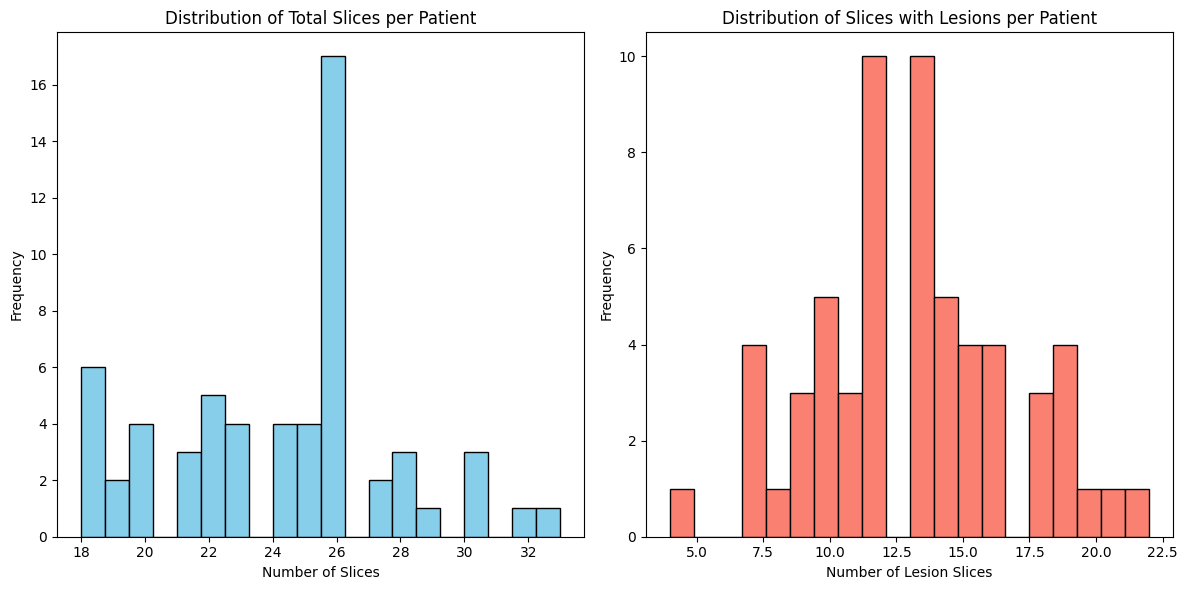

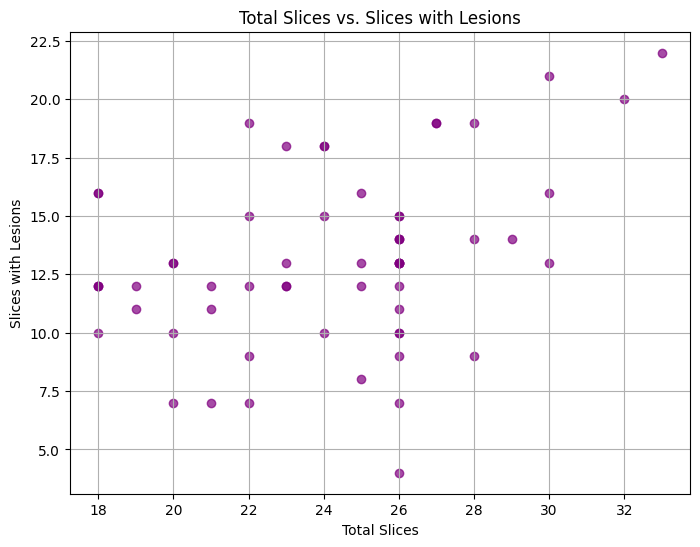

In [ ]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def load_nii_file(filepath):
    """Load a .nii file and return the image data as a numpy array."""
    img = nib.load(filepath)
    return img.get_fdata()

def get_slice_statistics(patient_folder):
    """Get statistics on the number of slices and number of slices with lesions."""

    # Patient number
    patient_number = patient_folder.split('-')[1]

    # Load the brain scan and lesion segmentation files
    flair_path = os.path.join(patient_folder, f"{os.path.basename(patient_number)}-Flair.nii")
    lesion_seg_path = os.path.join(patient_folder, f"{os.path.basename(patient_number)}-LesionSeg-Flair.nii")

    # Load the brain scan and lesion segmentation
    flair_img = load_nii_file(flair_path)
    lesion_mask = load_nii_file(lesion_seg_path)

    # Total number of slices in the brain scan (third dimension)
    total_slices = flair_img.shape[2]

    # Count slices with lesions (slices where the mask has non-zero values)
    slices_with_lesions = np.sum(np.any(lesion_mask > 0, axis=(0, 1)))

    return total_slices, slices_with_lesions

def eda_on_brain_mri_dataset(data_dir):
    """Perform EDA on the brain MRI dataset, calculating slice statistics and lesion statistics."""
    patient_folders = [os.path.join(data_dir, folder) for folder in os.listdir(data_dir) if folder.startswith("Patient")]

    stats = []

    # Iterate over all patient folders and calculate statistics
    for patient_folder in patient_folders:
        total_slices, slices_with_lesions = get_slice_statistics(patient_folder)
        stats.append({
            "Patient": os.path.basename(patient_folder),
            "Total Slices": total_slices,
            "Slices with Lesions": slices_with_lesions
        })

    # Convert the stats to a DataFrame for easy analysis
    stats_df = pd.DataFrame(stats)

    # Additional metrics
    stats_df['Lesion Slice Ratio'] = stats_df['Slices with Lesions'] / stats_df['Total Slices']

    return stats_df

# Define the data folder containing the brain MRI dataset
data_dir = "brain_mri_dataset"

# Perform EDA and gather the statistics
stats_df = eda_on_brain_mri_dataset(data_dir)

# Display the statistics DataFrame
print(stats_df)

# Summary statistics
print("\nSummary statistics:")
print(stats_df.describe())

# Plotting the distribution of total slices and lesion slices
plt.figure(figsize=(12, 6))

# Distribution of total slices
plt.subplot(1, 2, 1)
plt.hist(stats_df['Total Slices'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Total Slices per Patient')
plt.xlabel('Number of Slices')
plt.ylabel('Frequency')

# Distribution of slices with lesions
plt.subplot(1, 2, 2)
plt.hist(stats_df['Slices with Lesions'], bins=20, color='salmon', edgecolor='black')
plt.title('Distribution of Slices with Lesions per Patient')
plt.xlabel('Number of Lesion Slices')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Scatter plot of total slices vs lesion slices
plt.figure(figsize=(8, 6))
plt.scatter(stats_df['Total Slices'], stats_df['Slices with Lesions'], alpha=0.7, color='purple')
plt.title('Total Slices vs. Slices with Lesions')
plt.xlabel('Total Slices')
plt.ylabel('Slices with Lesions')
plt.grid(True)
plt.show()



Lesion Size (Number of Voxels) - Descending Order:
       Patient  Lesion Voxels  Lesion Percentage
38  Patient-31          60999           0.984943
52  Patient-40          60863           0.804066
18  Patient-58          48148           0.839634
26  Patient-45          23795           0.378211
41  Patient-35          23735           0.517382
9   Patient-38          21501           1.025248
42  Patient-52          20338           0.352651
39  Patient-56          15630           0.211995
56  Patient-30          14537           0.964422
58  Patient-48          13086           0.798706
19  Patient-13          12834           1.087952
47  Patient-57          11366           0.171290
10  Patient-44          10579           0.620857
43  Patient-10           8699           0.485435
5   Patient-55           8502           0.584288
53  Patient-34           7437           0.101321
24  Patient-17           6539           0.554318
51  Patient-54           6434           0.465422
45   Patient-7   

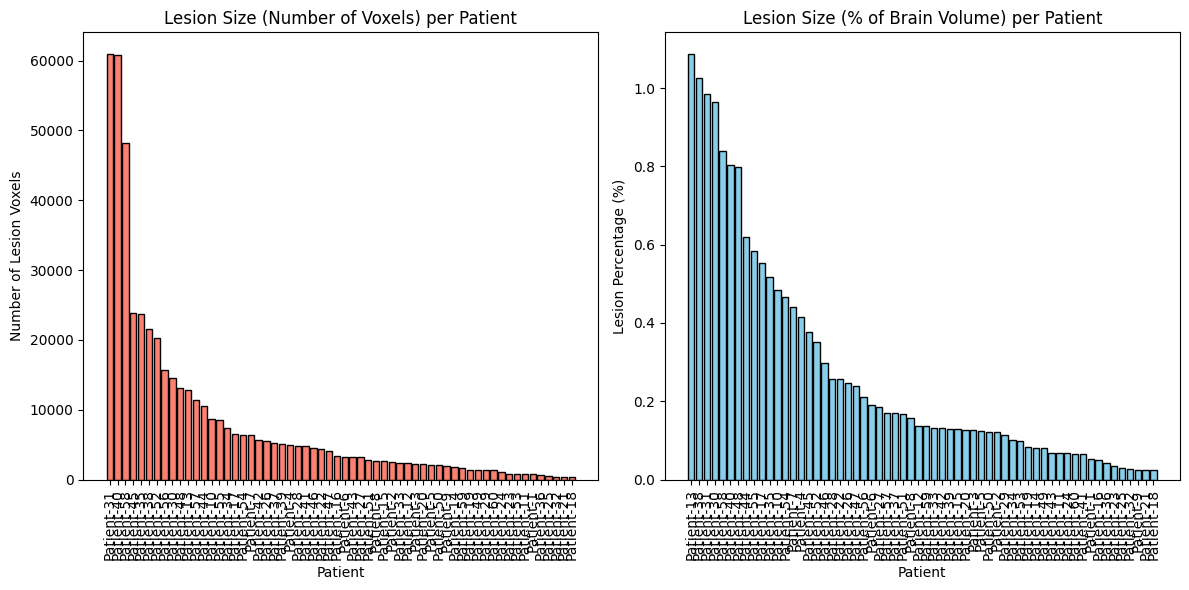

In [ ]:
import os
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the root directory containing the patient folders
data_dir = "brain_mri_dataset"  # Change this to the location of your "brain_mri_dataset" folder

def calculate_lesion_size(patient_folder):
    """Calculate the lesion size (number of non-zero voxels) and percentage of total brain volume."""
    lesion_seg_file = [f for f in os.listdir(patient_folder) if f.endswith('-LesionSeg-Flair.nii')]

    if lesion_seg_file:
        lesion_seg_path = os.path.join(patient_folder, lesion_seg_file[0])
        lesion_img = nib.load(lesion_seg_path).get_fdata()

        # Total number of voxels in the brain scan
        total_voxels = lesion_img.size

        # Number of voxels with lesions (non-zero values)
        lesion_voxels = np.count_nonzero(lesion_img)

        # Percentage of brain affected by lesions
        lesion_percentage = (lesion_voxels / total_voxels) * 100

        return lesion_voxels, lesion_percentage
    return None, None

def lesion_size_analysis(data_dir):
    """Perform lesion size analysis and plot the results."""
    lesion_data = []

    # Iterate through each patient folder
    for patient_folder in os.listdir(data_dir):
        patient_path = os.path.join(data_dir, patient_folder)

        if os.path.isdir(patient_path):
            lesion_voxels, lesion_percentage = calculate_lesion_size(patient_path)

            if lesion_voxels is not None:
                lesion_data.append({
                    "Patient": patient_folder,
                    "Lesion Voxels": lesion_voxels,
                    "Lesion Percentage": lesion_percentage
                })

    # Convert the lesion data to a pandas DataFrame
    lesion_df = pd.DataFrame(lesion_data)

    # Create two DataFrames, one sorted by lesion voxels, another by lesion percentage
    lesion_df_voxels_sorted = lesion_df.sort_values(by="Lesion Voxels", ascending=False)
    lesion_df_percentage_sorted = lesion_df.sort_values(by="Lesion Percentage", ascending=False)

    return lesion_df_voxels_sorted, lesion_df_percentage_sorted

# Perform the lesion size analysis and get the sorted DataFrames
lesion_df_voxels_sorted, lesion_df_percentage_sorted = lesion_size_analysis(data_dir)

# Display DataFrame sorted by Lesion Voxels (descending)
print("\nLesion Size (Number of Voxels) - Descending Order:")
print(lesion_df_voxels_sorted)

# Display DataFrame sorted by Lesion Percentage (descending)
print("\nLesion Size (% of Brain Volume) - Descending Order:")
print(lesion_df_percentage_sorted)

# Plot the lesion size (number of voxels) for each patient
def plot_lesion_sizes(df_voxels, df_percentage):
    """Plot the lesion sizes by number of voxels and percentage of brain volume."""
    plt.figure(figsize=(12, 6))

    # Bar plot for absolute lesion sizes
    plt.subplot(1, 2, 1)
    plt.bar(df_voxels["Patient"], df_voxels["Lesion Voxels"], color='salmon', edgecolor='black')
    plt.xticks(rotation=90)
    plt.title('Lesion Size (Number of Voxels) per Patient')
    plt.xlabel('Patient')
    plt.ylabel('Number of Lesion Voxels')

    # Bar plot for lesion size as a percentage of brain volume
    plt.subplot(1, 2, 2)
    plt.bar(df_percentage["Patient"], df_percentage["Lesion Percentage"], color='skyblue', edgecolor='black')
    plt.xticks(rotation=90)
    plt.title('Lesion Size (% of Brain Volume) per Patient')
    plt.xlabel('Patient')
    plt.ylabel('Lesion Percentage (%)')

    plt.tight_layout()
    plt.show()

# Plot the results
plot_lesion_sizes(lesion_df_voxels_sorted, lesion_df_percentage_sorted)

## Organizing Data

Plotting an overview regarding the brain-scan orientations

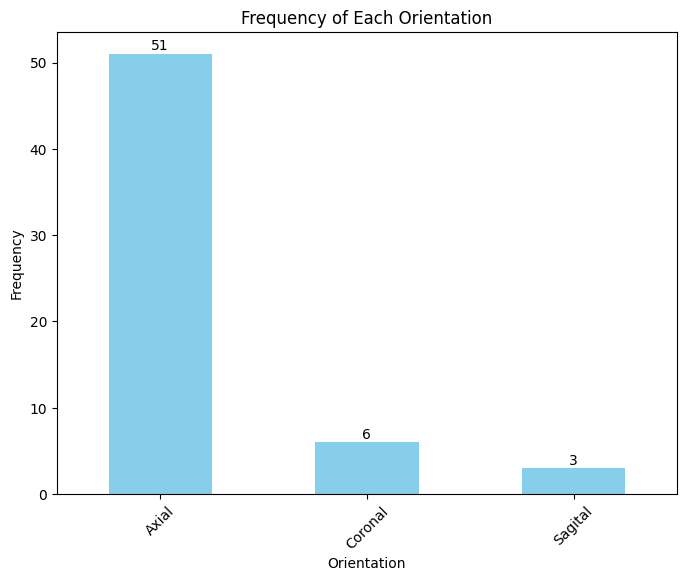

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the metadata CSV file
metadata_path = "Metadata.csv"
metadata_df = pd.read_csv(metadata_path)

# Plot the frequency of each Orientation
orientation_counts = metadata_df['Orientation'].value_counts()

# Create a bar plot for the orientation counts
plt.figure(figsize=(8,6))
ax = orientation_counts.plot(kind='bar', color='skyblue')

# Add titles and labels
plt.title('Frequency of Each Orientation')
plt.xlabel('Orientation')
plt.ylabel('Frequency')

# Annotate the bars with the counts
for i, count in enumerate(orientation_counts):
    ax.text(i, count + 0.1, str(count), ha='center', va='bottom')

# Show the plot
plt.xticks(rotation=45)
plt.show()


In [9]:
# Filter patients where Orientation doesn' equal 'Axial'
non_axial_patients_df = metadata_df[metadata_df['Orientation'] != 'Axial']

# Select and show specific columns (ID, Gender, Age, Orientation) for non-Axial patients
columns_to_display = ['ID', 'Gender', 'Age', 'Orientation']
non_axial_patients_df_filtered = non_axial_patients_df[columns_to_display]

print("Patients with non-Axial Orientation (showing selected columns):")
print(non_axial_patients_df_filtered)

Patients with non-Axial Orientation (showing selected columns):
    ID Gender  Age Orientation
13  14      F   30     Coronal
22  23      F   45     Coronal
31  32      F   32     Sagital
40  41      F   26     Coronal
47  48      M   38     Sagital
52  53      F   37     Coronal
53  54      F   54     Coronal
55  56      M   30     Sagital
56  57      M   17     Coronal


The additional orientations (coronal, sagital) are insufficiently represented and will therefore be excluded from training. The following code will organize data in folders for training, excluding those with a different orientation than 'Axial'

In [6]:
import os
import shutil
import pandas as pd
import random

# Set constants
N_TRAIN = 35
N_TEST = 8

# Define the root folder for data organization
data_folder = "data"

# Define destination directories under the data folder
train_folder = os.path.join(data_folder, "train")
test_folder = os.path.join(data_folder, "test")
validation_folder = os.path.join(data_folder, "validation")

# Load the metadata CSV file
metadata_path = "Metadata.csv"
metadata_df = pd.read_csv(metadata_path)

# Filter patients where Orientation equals 'Axial'
axial_patients = metadata_df[metadata_df['Orientation'] == 'Axial']['ID'].tolist()
axial_patient_folders = [f"Patient-{patient_id}" for patient_id in axial_patients]

# Set a random seed for reproducibility
random.seed(42)

# Function to organize patient data into train, test, and validation folders
def organize_data(extracted_folder, train_folder, test_folder, validation_folder, axial_patient_folders):
    # Create the data folder if it doesn't exist
    os.makedirs(data_folder, exist_ok=True)

    # Shuffle the list of axial patient folders
    random.shuffle(axial_patient_folders)

    # Split into train, test, and validation
    train_patients = axial_patient_folders[:N_TRAIN]
    test_patients = axial_patient_folders[N_TRAIN:N_TRAIN+N_TEST]
    validation_patients = axial_patient_folders[N_TRAIN+N_TEST:]

    # Create directories if they don't exist
    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)
    os.makedirs(validation_folder, exist_ok=True)

    # Move patient folders to respective directories
    for patient in train_patients:
        shutil.move(os.path.join(extracted_folder, patient), train_folder)

    for patient in test_patients:
        shutil.move(os.path.join(extracted_folder, patient), test_folder)

    for patient in validation_patients:
        shutil.move(os.path.join(extracted_folder, patient), validation_folder)

    print("Organized data into train, test, and validation folders.")

# Organize the data into train, test, and validation folders considering only 'Axial' patients
organize_data("brain_mri_dataset", train_folder, test_folder, validation_folder, axial_patient_folders)


Organized data into train, test, and validation folders.


## References

M Muslim, Ali (2022), “Brain MRI Dataset of Multiple Sclerosis with Consensus Manual Lesion Segmentation and Patient Meta Information”, Mendeley Data, V1, doi: 10.17632/8bctsm8jz7.1

## RANDOM CODE

Reverse data-structure

In [ ]:
import os
import shutil

# Define the root folder where the patient folders will be moved back
destination_folder = "brain_mri_dataset"  # Change this to the location of your "brain_mri_dataset" folder

# Define source directories (train, test, validation)
train_folder = os.path.join("data", "train")
test_folder = os.path.join("data", "test")
validation_folder = os.path.join("data", "validation")

# Function to move all patient folders back to the original folder
def move_back_to_dataset(destination_folder, train_folder, test_folder, validation_folder):
    # Create the destination folder if it doesn't exist
    os.makedirs(destination_folder, exist_ok=True)

    # Move all patient folders from the train folder
    for patient_folder in os.listdir(train_folder):
        shutil.move(os.path.join(train_folder, patient_folder), destination_folder)

    # Move all patient folders from the test folder
    for patient_folder in os.listdir(test_folder):
        shutil.move(os.path.join(test_folder, patient_folder), destination_folder)

    # Move all patient folders from the validation folder
    for patient_folder in os.listdir(validation_folder):
        shutil.move(os.path.join(validation_folder, patient_folder), destination_folder)

    print("Moved all patient folders back to", destination_folder)

# Call the function to move patient folders back
move_back_to_dataset(destination_folder, train_folder, test_folder, validation_folder)


Moved all patient folders back to brain_mri_dataset
